In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [2]:
db = mysql.connector.connect(host = 'localhost',
                           username = 'root',
                          password = 'Rashtrartha@118251',
                           database = 'ecommerce')
cur = db.cursor()

# ***Queries*** 

# *Basic Queries*

*1. List all unique cities where customers are located.*

In [66]:
query = """select distinct(customer_city) from customers"""

cur.execute(query)
df = cur.fetchall()
data = pd.DataFrame(df)
data.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


*2. Count the number of orders placed in 2017.*

In [6]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)
df = cur.fetchall()
df[0][0]

45101

*3. Find the total product saled and sales per category.*

In [67]:
query = """SELECT product_category ,COUNT(product_category)  
FROM products
group by product_category"""

cur.execute(query)
df = cur.fetchall()
data = pd.DataFrame(df)
data.head()



,0,1
0,perfumery,868
1,Art,55
2,sport leisure,2867
3,babies,919
4,housewares,2335


In [14]:
query = """SELECT UPPER(products.product_category) as CATEGORY, round(sum(payments.payment_value),2) as SALES
from products join order_items
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by product_category"""

cur.execute(query)
df = cur.fetchall()
df
#dataframe creating
data = pd.DataFrame(df, columns = ['Category','Sales'])
data.head()

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33


*4. Calculate the percentage of orders that were paid in installments.*

In [19]:
query = """SELECT (SUM(CASE when payment_installments >= 1 THEN 1 ELSE 0 END)/COUNT(*))*100 
FROM payments"""

cur.execute(query)
df = cur.fetchall()
df[0][0]

Decimal('99.9981')

*5. Count the number of customers from each state.*

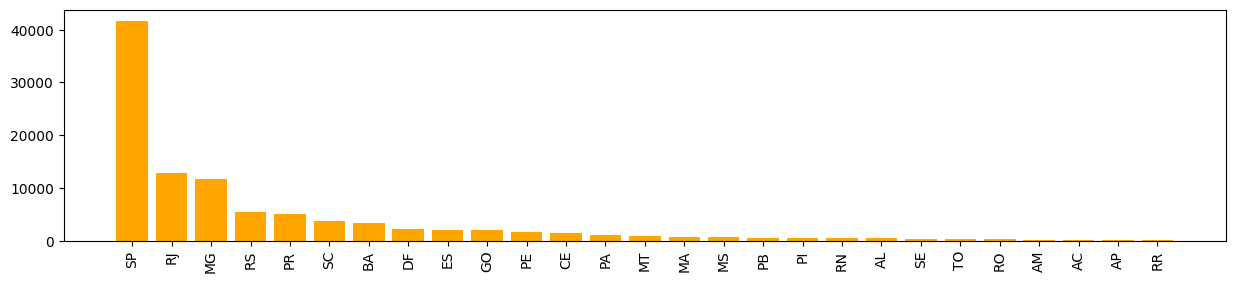

In [64]:
query = """SELECT customer_state as STATE, COUNT(customer_id) as TOTAL_CUSTOMERS
FROM customers
GROUP BY customer_state"""

cur.execute(query)
df = cur.fetchall()

data = pd.DataFrame(df, columns = ['State','Total Customers'])


data.sort_values('Total Customers', ascending = False, inplace = True)

data

plt.figure(figsize = (15, 3))
plt.bar(data['State'], data['Total Customers'], color = 'orange')

plt.xticks(rotation = 90)
plt.show()


# *Intermediate Queries*

*1. Calculate the number of orders per month in 2018.*

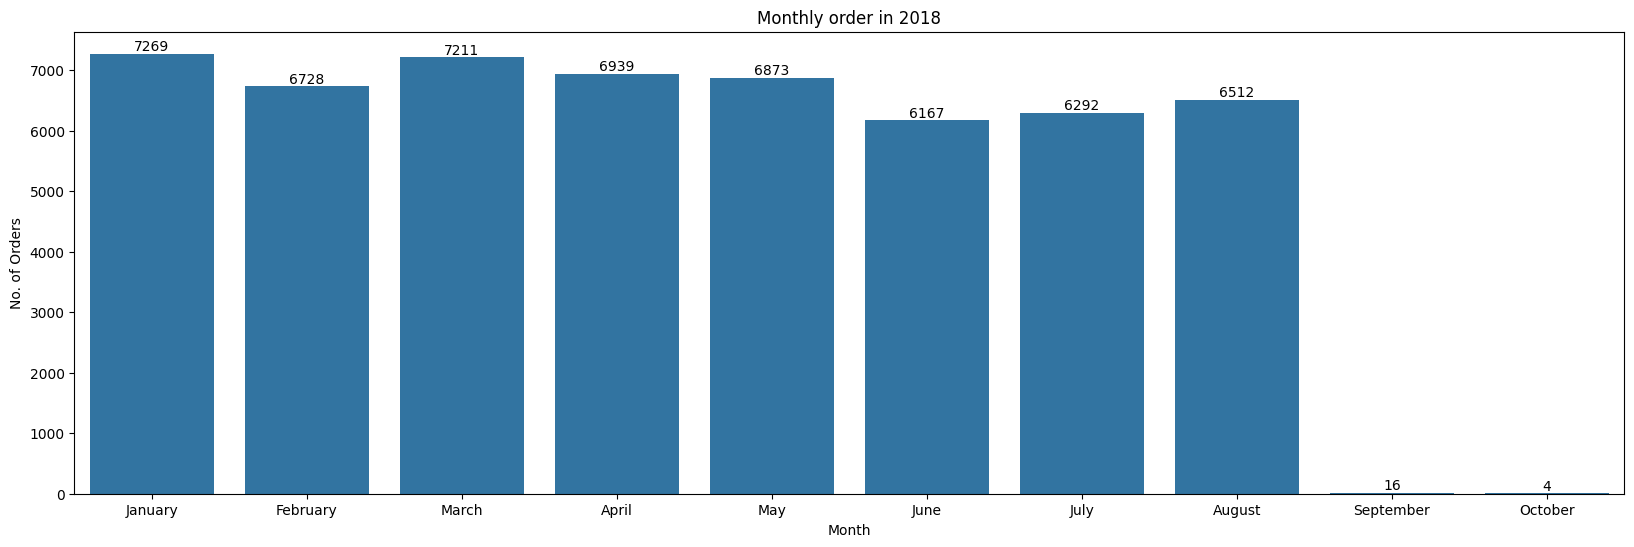

In [83]:
query = """SELECT MONTHNAME(order_purchase_timestamp), COUNT(order_id)
FROM orders
WHERE YEAR(order_purchase_timestamp) = 2018
GROUP BY MONTHNAME(order_purchase_timestamp)
ORDER BY MONTHNAME(order_purchase_timestamp)"""

cur.execute(query)
df = cur.fetchall()
o = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October']
df1 = pd.DataFrame(df, columns = ['Month', 'No. of Orders'])
plt.figure(figsize = (20, 6))
ax = sns.barplot(x = df1['Month'], y = df1['No. of Orders'], data = df1, order = o)
for bars in ax.containers : 
    ax.bar_label(bars)
plt.title('Monthly order in 2018')
#plt.xticks(rotation = 45)
plt.show()

*2. Find the average number of products per order, grouped by customer city.*

In [88]:
query = """WITH count_per_order AS
(SELECT orders.order_id, orders.customer_id, count(order_items.order_id) as oc
FROM orders JOIN order_items
ON orders.order_id = order_items.order_id
GROUP BY orders.order_id, orders.customer_id)

SELECT UPPER(customers.customer_city), ROUND(AVG(count_per_order.oc),2) as avg_count_per_order
FROM customers join count_per_order
ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city
ORDER BY avg_count_per_order DESC"""

cur.execute(query)
df = cur.fetchall()
df1 = pd.DataFrame(df, columns = ['City Name', 'Avg Order'])
df1.head(10)


,City Name,Avg Order
0,PADRE CARVALHO,7.00
1,CELSO RAMOS,6.50
2,DATAS,6.00
3,CANDIDO GODOI,6.00
4,MATIAS OLIMPIO,5.00
5,MORRO DE SAO PAULO,4.00
6,TEIXEIRA SOARES,4.00
7,CURRALINHO,4.00
8,CIDELANDIA,4.00
9,PICARRA,4.00


*3. Calculate the percentage of total revenue contributed by each product category*

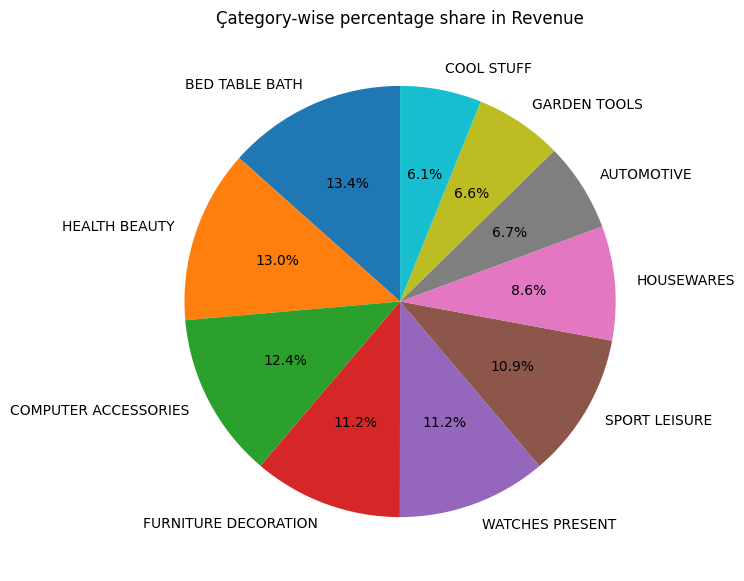

In [108]:

df1 = pd.DataFrame(df, columns = ['Product Category', '% Share in Total Revenue'])
df2 = df1.head(10)
plt.figure(figsize = (7,7))
plt.pie(df2['% Share in Total Revenue'], labels = df2['Product Category'], autopct = '%1.1f%%', startangle = 90)
plt.title('Çategory-wise percentage share in Revenue')
plt.show()

*4. Identify the correlation between product price and the number of times a product has been purchased.*

In [124]:
import numpy as np
query = """SELECT products.product_category CATEGORY, 
COUNT(order_items.product_id) ORDERS, 
ROUND(AVG(order_items.price),2) PRICE
FROM products JOIN order_items
on products.product_id = order_items.product_id
group by products.product_category; """

cur.execute(query)
df = cur.fetchall()
df1 = pd.DataFrame(df, columns = ['Category', 'Orders', 'Price'])
df1.head()
arr1 = df1['Orders']
arr2 = df1['Price']
a = np.corrcoef([arr1, arr2])
print('The correlation b/w Orders and Price is', a[0][1], 'i.e. No significant trend is seen for the same.')



The correlation b/w Orders and Price is -0.10631514167157562 i.e. No significant trend is seen for the same.


*5. Calculate the total revenue generated by each seller, and rank them by revenue.*

In [132]:
query = """SELECT *, rank() over (order by Revenue DESC) as RK
FROM
(SELECT order_items.seller_id ID, ROUND(SUM(payments.payment_value),2) Revenue
FROM order_items join payments
on order_items.order_id = payments.order_id
GROUP by order_items.seller_id) as a  """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Seller ID', 'Revenue', 'Ranking'])
df = df.head()
df
#sns.barplot(x = 'Seller ID', y = 'Revenue', data = df)
#plt.xticks(rotation = 90)
#plt.show()


,Seller ID,Revenue,Ranking
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5


# *Advanced Queries*

*1. Calculate the moving average of order values for each customer over their order history.*

In [134]:
query = """SELECT customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg 
from
(SELECT orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment
FROM payments join orders
on payments.order_id = orders.order_id) as a;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Customer ID', 'Timestamp', 'Payment', 'Moving Average'])
df


,Customer ID,Timestamp,Payment,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


*2. Calculate the cumulative sales per month for each year.*

<Axes: xlabel='Year', ylabel='Cumulative Sales'>

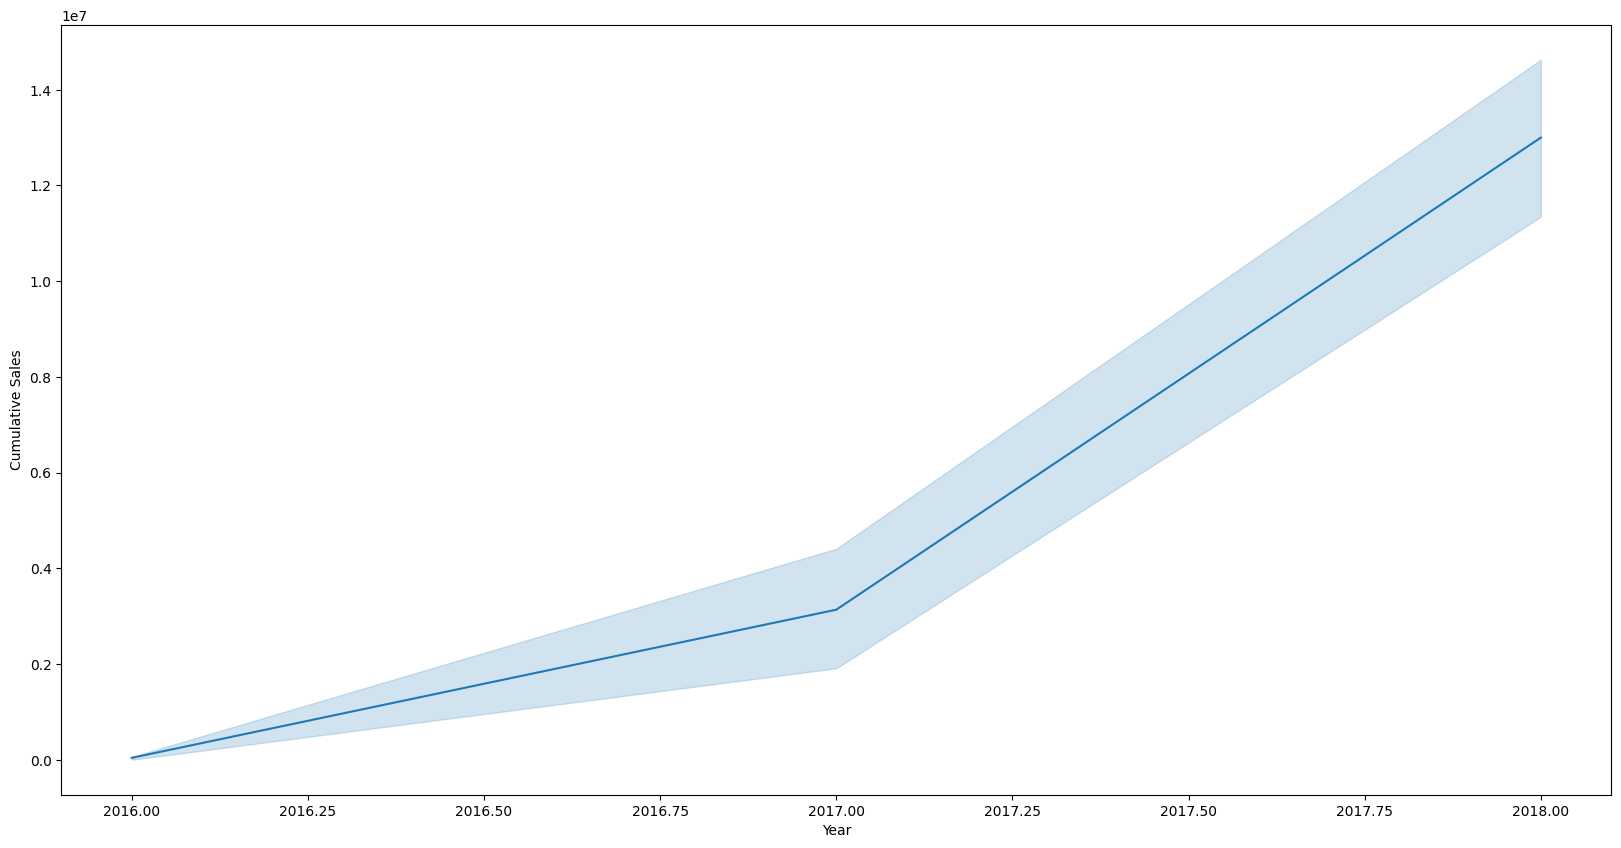

In [144]:
query = """SELECT years, months, sum(payment) 
over(order by years, months) cumulative_sales from
(SELECT YEAR(orders.order_purchase_timestamp) as years, 
MONTH(orders.order_purchase_timestamp) as months, 
ROUND(SUM(payments.payment_value),2) as payment
FROM orders join payments
ON orders.order_id = payments.order_id
group by years, months
order by years, months) as a; """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Year', 'Month (in No.)', 'Cumulative Sales'])
plt.figure(figsize =(20, 10))
sns.lineplot(data = df, x = df['Year'], y = df['Cumulative Sales'])

*3. Calculate the year-over-year growth rate of total sales.*

In [156]:
query = """

with a as (SELECT YEAR(orders.order_purchase_timestamp) as years, 
ROUND(SUM(payments.payment_value),2) as payment
FROM orders join payments
ON orders.order_id = payments.order_id
group by years
order by years) 

SELECT years, 
Round(((payment - lag(payment,1) over(order by years))/ (lag(payment,1) over(order by years)))*100,2) as YOY 
from a
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Year', 'YOY % Growth'])
df
# columns = ['Year', 'Month (in No.)', 'Cumulative Sales']

,Year,YOY % Growth
0,2016,NaN
1,2017,12112.7
2,2018,20.0


*4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.*

In [162]:
query = """

WITH a as (SELECT customers.customer_id, 
MIN(orders.order_purchase_timestamp) first_order
FROM customers join orders 
ON customers.customer_id = orders.customer_id
GROUP BY customers.customer_id),

b as (SELECT a.customer_id, COUNT(DISTINCT orders.order_purchase_timestamp) next_order 
FROM a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)

SELECT 100* (COUNT(DISTINCT a.customer_id))/(COUNT(DISTINCT b.customer_id)) Retention
FROM a LEFT JOIN b 
ON a.customer_id = b.customer_id;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df
# columns = ['Year', 'Month (in No.)', 'Cumulative Sales']
print('No customers has seen ordering b/w the time interval of 6 months')
print(df)


No customers has seen ordering b/w the time interval of 6 months
      0
0  None


*5. Identify the top 3 customers who spent the most money in each year.*

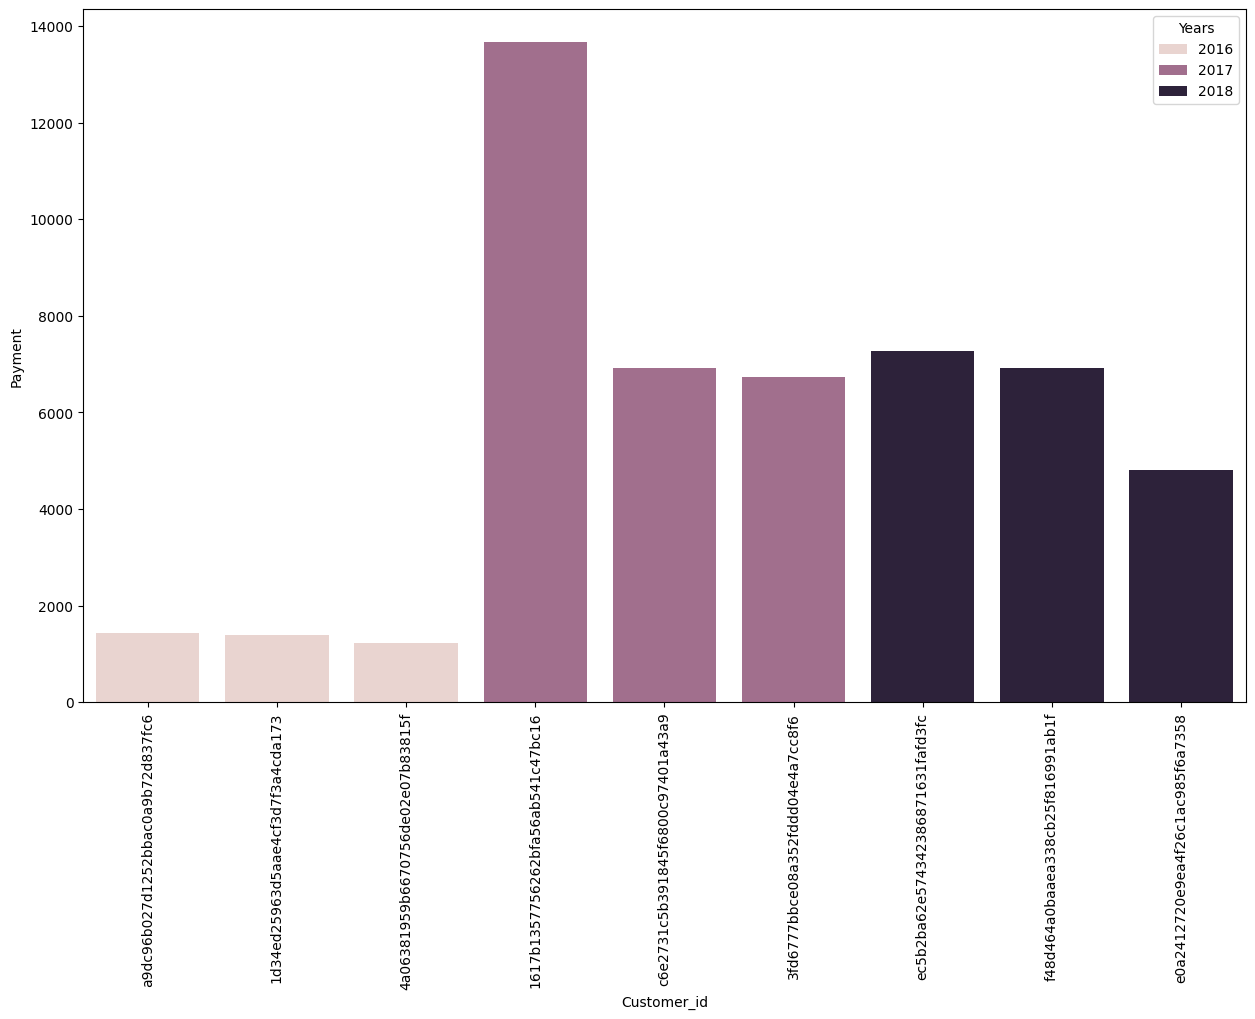

In [172]:
query = """

SELECT years, customer_id, payment, d_rank 
from
(SELECT year(orders.order_purchase_timestamp) years, 
orders.customer_id, 
sum(payments.payment_value) as payment, 
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
FROM orders join payments 
on orders.order_id = payments.order_id
GROUP BY year(orders.order_purchase_timestamp), orders.customer_id) as a
where d_rank < 4
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Years', 'Customer_id', 'Payment', 'Rank'])
df
plt.figure(figsize = (15, 9))
sns.barplot( x = 'Customer_id', y = 'Payment', hue = 'Years', data = df,)
plt.xticks(rotation = 90)
plt.show(
)